# Linear Regression Example

This is an example of a simple linear regression problem: using a gradient descent optimisation algorithm to fit for the gradient and intercept of the function $y=mx+c$.

This example allows us to explore a few of the hyperparameters and how they affect the convergence of the optimisation algorithm.  The parameters we can tweak are the learning_rate and training_epochs.  
* If the learning_rate is too large then there can be issues with convergence; the gradient descent algorithm can diverge.
* If the learning_rate is suitable, but training_epochs is set to too small a number, then the optimisation will not be able to converge.  Similarly if training_epochs is set to too large a number then the algorithm will have converged long before the specified number of epochs has been reached. This second issue is usually addressed by inserting convergence criteria in an optimisation loop.
For a suitable learning_rate, the number of steps required to reach convergence will depend on how far away from the true model parameters the starting parameters (our intial guess) are.  You can explore this issue by changing the gradient and intercept, noting that the script generates initial values that are bounded by $[0, 1]$.

We start the training in the nominal version with the following parameters:
* learning_rate = 0.005
* training_epochs = 100
* gradient = 1.0
* intercept = 0.0
* noise     = 0.1

In [65]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Network training parameters
learning_rate    = 0.005
training_epochs  = 100
min_x = 0
max_x = 1
Ngen  = 100
gradient  = 1.0
intercept = 0.0
noise     = 0.1  # data are inherently noisy, so we generate noise

print("--------------------------------------------")
print("Number of examples to generate = ", Ngen)
print("Learning rate            alpha = ", learning_rate)
print("Number of training epochs      = ", training_epochs)
print("--------------------------------------------")

--------------------------------------------
Number of examples to generate =  100
Learning rate            alpha =  0.005
Number of training epochs      =  100
--------------------------------------------


TensorFlow models can be broken into two parts, the first part allows the user to construct a graph.  This is the logical structure of the algorithm that will be excecuted to learn the model parameters. The second part is excecution of the graph. This is an iterative process and as will be seen below, the parameter update is essentially hidden behind the evaluation of hte variable train_step.  Here we define the graph that needs to be excecuted.

In [66]:
# tf Graph input:
#  x: is the tensor for the input data (the placeholder entry None is used for that;
#     and the number of features input (n_input = 1).
#
#
#  y: is the tensor input data computed from the generated data x values
#
#  yhat: is the tensor for the output value of the function that is being approximated by
#     the the model, calculated from yhat = m*x + c
#
x = tf.placeholder(tf.float32, [None, 1], name="x")
y = tf.placeholder(tf.float32, [None, 1], name="y")

# parameters of the model are m (gradient) and c (constant offset)
#   - pick random starting values for fit convergence
c = tf.Variable(tf.random_uniform([1]), name="c")
m = tf.Variable(tf.random_uniform([1]), name="m")
yhat = m * x + c

# Use the L2 norm loss function for minimsation. This is equivalent to minimising a chi2 
# all of the data points have equal uncertainty, and hence the optimal solution for the
# parameters is independent of the uncertainty.
loss = tf.reduce_sum((y-yhat) * (y-yhat))

# use a gradient descent optimiser to miniise the loss; here we specify the learning_rate step
# size for the minimisation
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

With the graph set up above, we now need to (i) prepare the training data, and (ii) start a TensorFlow session, and use this to initialise the variables m and c so that we can start the optimisation process.  

The data sample is simply a uniformly generated set of data in the range $[min_x, max_x]=[0, 1]$ for x, and y is evaluated as y=mx+c, with a random noise term added to simulate noise that would be inherent in any data set.

There are several ways to evaluate tensors in TensorFlow.  Here a session is used to evaluate tf objects. You may wish to explore the website for the other alternatives.

In [67]:
# prepare data - data_x and data_y are np arrays that will get fed into the optimisation
# set the seed for random number generation to ensure we always get the same data
np.random.seed(0)
data_x = (max_x-min_x)*np.random.random([Ngen, 1])+min_x
data_y = np.zeros([Ngen,1])
for i in range(Ngen):
    data_y[i] = gradient*data_x[i]+intercept + noise*np.random.randn()


# prepare the session for evaluation and initialise the variables.
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

The rest of this notebook consists of graph evaluation, and output of the results.  The loop over training_epochs results in train_set being evaluated the specified number of times.  As the train_set variable is the gradient descent optimiser, each evaluation results in one iteration of the optimisation being performed.  For each iteration the whole data sample is fed into the calculation. This is not optimal for large data sets and you may wish to explore large samples and extend the notebook to do batch learning (see the accompanying notes on neural networks for details of batch learning).

The loss is evaluated at each training step, again using the full amount of training data, so that we can plot the evolution of loss against training epoch.  

The rest of the code prints out the values of m and c obtained, displays how the fitted model agrees with the data, and the evolution of loss vs epoch.

Epoch   m         c
Optimisation process has finished.  The optimal values of parameters are:
  m =  [0.9676474]  [input value =  1.0 ]
  c =  [0.11149117]  [input value =  0.0 ]
  loss function for the optimal parameters =  24.810972


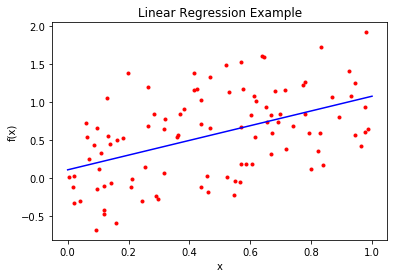

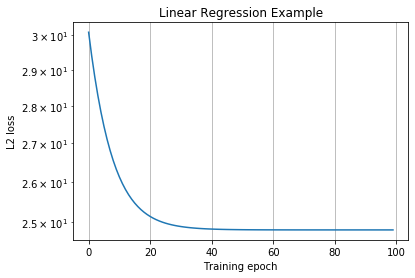

In [68]:
# epoch and chi2 are the training step and the chi2 sum (neglecting the error normalisation)
# for the problem.  These will be logged to inspect the fit convergence obtained.
epoch      = []
loss_vals  = []
print("Epoch   m         c")
for step in range(training_epochs):
    # run the minimiser
    sess.run(train_step, feed_dict={x: data_x, y: data_y})

    # log the data and print output
    epoch.append(step)
    loss_vals.append(sess.run(loss, feed_dict={x: data_x, y: data_y}))
    # uncomment this line for verbose printout
    #print(step, sess.run(m), sess.run(c), chi2[step])


# print optimisation results
print("Optimisation process has finished.  The optimal values of parameters are:")
print("  m = ", sess.run(m), " [input value = ", gradient, "]" )
print("  c = ", sess.run(c), " [input value = ", intercept, "]" )
print("  loss function for the optimal parameters = ", loss_vals[training_epochs-1])

plt.plot(data_x, data_y, 'r.')
plt.plot([min_x, max_x], [sess.run(c), sess.run(m)*max_x+sess.run(c)], 'b-')
plt.ylabel('f(x)')
plt.xlabel('x')
plt.title('Linear Regression Example')
plt.show()

plt.semilogy(epoch, loss_vals)
plt.grid(True)
plt.ylabel('L2 loss')
plt.xlabel('Training epoch')
plt.title('Linear Regression Example')
plt.show()

Some suggestions of things to explore with this example:
* change the learning rate to some other value; both smaller (down to 0.0001) and larger (to 0.02) to see how the convergence properties change;
* change the gradient used to see how the convergence properties change; try numbers in the range of 0.1 through 100;
* try changing the value of the intercept m to see what happens to the optimisation;
* try changing the value of the noise term to see what happens.